In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 920)
(772408, 8)
validation
(101248, 920)
(101248, 8)
test
(98888, 920)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1633160 (6.23 MB)


Trainable params: 1633160 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:39 - loss: 2.5135 - STD: 0.0645 - MAE: 0.2269

 4/78 [>.............................] - ETA: 1s - loss: 1.8514 - STD: 0.0811 - MAE: 0.1987  

 7/78 [=>............................] - ETA: 1s - loss: 1.6478 - STD: 0.1407 - MAE: 0.1716

10/78 [==>...........................] - ETA: 1s - loss: 1.5740 - STD: 0.1732 - MAE: 0.1574

13/78 [====>.........................] - ETA: 1s - loss: 1.5241 - STD: 0.1857 - MAE: 0.1515

16/78 [=====>........................] - ETA: 3s - loss: 1.4971 - STD: 0.1873 - MAE: 0.1503

19/78 [======>.......................] - ETA: 3s - loss: 1.4722 - STD: 0.1858 - MAE: 0.1504

22/78 [=======>......................] - ETA: 2s - loss: 1.4526 - STD: 0.1852 - MAE: 0.1504

25/78 [========>.....................] - ETA: 2s - loss: 1.4363 - STD: 0.1860 - MAE: 0.1497

28/78 [=========>....................] - ETA: 2s - loss: 1.4230 - STD: 0.1877 - MAE: 0.1488

31/78 [==========>...................] - ETA: 1s - loss: 1.4132 - STD: 0.1892 - MAE: 0.1480

34/78 [============>.................] - ETA: 1s - loss: 1.4051 - STD: 0.1899 - MAE: 0.1476

37/78 [=============>................] - ETA: 1s - loss: 1.3987 - STD: 0.1900 - MAE: 0.1475

40/78 [==============>...............] - ETA: 1s - loss: 1.3920 - STD: 0.1897 - MAE: 0.1475

42/78 [===============>..............] - ETA: 1s - loss: 1.3884 - STD: 0.1896 - MAE: 0.1474

45/78 [================>.............] - ETA: 1s - loss: 1.3837 - STD: 0.1896 - MAE: 0.1474

48/78 [=================>............] - ETA: 1s - loss: 1.3800 - STD: 0.1898 - MAE: 0.1472

51/78 [==================>...........] - ETA: 0s - loss: 1.3758 - STD: 0.1901 - MAE: 0.1470

53/78 [===================>..........] - ETA: 0s - loss: 1.3740 - STD: 0.1902 - MAE: 0.1470

56/78 [====================>.........] - ETA: 0s - loss: 1.3703 - STD: 0.1903 - MAE: 0.1469

58/78 [=====================>........] - ETA: 0s - loss: 1.3687 - STD: 0.1903 - MAE: 0.1468

60/78 [======================>.......] - ETA: 0s - loss: 1.3670 - STD: 0.1903 - MAE: 0.1468

62/78 [======================>.......] - ETA: 0s - loss: 1.3651 - STD: 0.1903 - MAE: 0.1468

65/78 [========================>.....] - ETA: 0s - loss: 1.3627 - STD: 0.1903 - MAE: 0.1467

68/78 [=========================>....] - ETA: 0s - loss: 1.3607 - STD: 0.1903 - MAE: 0.1467

71/78 [==========================>...] - ETA: 0s - loss: 1.3589 - STD: 0.1904 - MAE: 0.1466

74/78 [===========================>..] - ETA: 0s - loss: 1.3571 - STD: 0.1904 - MAE: 0.1465

77/78 [============================>.] - ETA: 0s - loss: 1.3558 - STD: 0.1905 - MAE: 0.1465

78/78 [==============================] - 4s 41ms/step - loss: 1.3552 - STD: 0.1905 - MAE: 0.1465 - val_loss: 1.2740 - val_STD: 0.1908 - val_MAE: 0.1453


Epoch 2/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3067 - STD: 0.1908 - MAE: 0.1453

 3/78 [>.............................] - ETA: 2s - loss: 1.3158 - STD: 0.1911 - MAE: 0.1457

 6/78 [=>............................] - ETA: 1s - loss: 1.3144 - STD: 0.1916 - MAE: 0.1453

 9/78 [==>...........................] - ETA: 1s - loss: 1.3174 - STD: 0.1919 - MAE: 0.1453

12/78 [===>..........................] - ETA: 1s - loss: 1.3170 - STD: 0.1919 - MAE: 0.1452

15/78 [====>.........................] - ETA: 1s - loss: 1.3179 - STD: 0.1918 - MAE: 0.1454

18/78 [=====>........................] - ETA: 1s - loss: 1.3163 - STD: 0.1915 - MAE: 0.1454

21/78 [=======>......................] - ETA: 1s - loss: 1.3159 - STD: 0.1916 - MAE: 0.1453

24/78 [========>.....................] - ETA: 1s - loss: 1.3175 - STD: 0.1917 - MAE: 0.1454

27/78 [=========>....................] - ETA: 1s - loss: 1.3171 - STD: 0.1917 - MAE: 0.1453

30/78 [==========>...................] - ETA: 1s - loss: 1.3168 - STD: 0.1916 - MAE: 0.1454

33/78 [===========>..................] - ETA: 1s - loss: 1.3164 - STD: 0.1916 - MAE: 0.1454

36/78 [============>.................] - ETA: 0s - loss: 1.3164 - STD: 0.1916 - MAE: 0.1453

39/78 [==============>...............] - ETA: 0s - loss: 1.3170 - STD: 0.1916 - MAE: 0.1454

42/78 [===============>..............] - ETA: 0s - loss: 1.3177 - STD: 0.1915 - MAE: 0.1455

45/78 [================>.............] - ETA: 0s - loss: 1.3181 - STD: 0.1913 - MAE: 0.1456

48/78 [=================>............] - ETA: 0s - loss: 1.3175 - STD: 0.1912 - MAE: 0.1456

51/78 [==================>...........] - ETA: 0s - loss: 1.3170 - STD: 0.1913 - MAE: 0.1455

54/78 [===================>..........] - ETA: 0s - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454

57/78 [====================>.........] - ETA: 0s - loss: 1.3171 - STD: 0.1916 - MAE: 0.1454

59/78 [=====================>........] - ETA: 0s - loss: 1.3168 - STD: 0.1915 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3170 - STD: 0.1914 - MAE: 0.1454

65/78 [========================>.....] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

67/78 [========================>.....] - ETA: 0s - loss: 1.3173 - STD: 0.1914 - MAE: 0.1455

69/78 [=========================>....] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

71/78 [==========================>...] - ETA: 0s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

73/78 [===========================>..] - ETA: 0s - loss: 1.3159 - STD: 0.1914 - MAE: 0.1454

75/78 [===========================>..] - ETA: 0s - loss: 1.3160 - STD: 0.1915 - MAE: 0.1454

77/78 [============================>.] - ETA: 0s - loss: 1.3157 - STD: 0.1915 - MAE: 0.1454

78/78 [==============================] - 2s 28ms/step - loss: 1.3157 - STD: 0.1915 - MAE: 0.1454 - val_loss: 1.2702 - val_STD: 0.1899 - val_MAE: 0.1454


Epoch 3/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3341 - STD: 0.1900 - MAE: 0.1468

 4/78 [>.............................] - ETA: 1s - loss: 1.3208 - STD: 0.1895 - MAE: 0.1463

 7/78 [=>............................] - ETA: 1s - loss: 1.3121 - STD: 0.1902 - MAE: 0.1456

10/78 [==>...........................] - ETA: 1s - loss: 1.3113 - STD: 0.1912 - MAE: 0.1452

13/78 [====>.........................] - ETA: 1s - loss: 1.3100 - STD: 0.1914 - MAE: 0.1450

16/78 [=====>........................] - ETA: 1s - loss: 1.3077 - STD: 0.1915 - MAE: 0.1450

19/78 [======>.......................] - ETA: 1s - loss: 1.3089 - STD: 0.1913 - MAE: 0.1451

22/78 [=======>......................] - ETA: 1s - loss: 1.3091 - STD: 0.1909 - MAE: 0.1452

25/78 [========>.....................] - ETA: 1s - loss: 1.3080 - STD: 0.1908 - MAE: 0.1452

28/78 [=========>....................] - ETA: 1s - loss: 1.3073 - STD: 0.1910 - MAE: 0.1451

31/78 [==========>...................] - ETA: 1s - loss: 1.3060 - STD: 0.1909 - MAE: 0.1451

33/78 [===========>..................] - ETA: 1s - loss: 1.3043 - STD: 0.1910 - MAE: 0.1449

36/78 [============>.................] - ETA: 0s - loss: 1.3024 - STD: 0.1913 - MAE: 0.1447

39/78 [==============>...............] - ETA: 0s - loss: 1.3001 - STD: 0.1915 - MAE: 0.1445

42/78 [===============>..............] - ETA: 0s - loss: 1.2988 - STD: 0.1915 - MAE: 0.1444

45/78 [================>.............] - ETA: 0s - loss: 1.2965 - STD: 0.1918 - MAE: 0.1442

48/78 [=================>............] - ETA: 0s - loss: 1.2944 - STD: 0.1919 - MAE: 0.1441

51/78 [==================>...........] - ETA: 0s - loss: 1.2930 - STD: 0.1920 - MAE: 0.1440

54/78 [===================>..........] - ETA: 0s - loss: 1.2901 - STD: 0.1924 - MAE: 0.1438

57/78 [====================>.........] - ETA: 0s - loss: 1.2870 - STD: 0.1926 - MAE: 0.1436

59/78 [=====================>........] - ETA: 0s - loss: 1.2847 - STD: 0.1928 - MAE: 0.1434

62/78 [======================>.......] - ETA: 0s - loss: 1.2820 - STD: 0.1930 - MAE: 0.1432

65/78 [========================>.....] - ETA: 0s - loss: 1.2793 - STD: 0.1932 - MAE: 0.1431

68/78 [=========================>....] - ETA: 0s - loss: 1.2761 - STD: 0.1934 - MAE: 0.1429

71/78 [==========================>...] - ETA: 0s - loss: 1.2732 - STD: 0.1937 - MAE: 0.1427

73/78 [===========================>..] - ETA: 0s - loss: 1.2715 - STD: 0.1938 - MAE: 0.1426

76/78 [============================>.] - ETA: 0s - loss: 1.2676 - STD: 0.1942 - MAE: 0.1424

78/78 [==============================] - 2s 28ms/step - loss: 1.2655 - STD: 0.1943 - MAE: 0.1422 - val_loss: 1.1596 - val_STD: 0.1938 - val_MAE: 0.1404


Epoch 4/10000


 1/78 [..............................] - ETA: 4s - loss: 1.1864 - STD: 0.1943 - MAE: 0.1405

 4/78 [>.............................] - ETA: 1s - loss: 1.1818 - STD: 0.1979 - MAE: 0.1387

 7/78 [=>............................] - ETA: 1s - loss: 1.1789 - STD: 0.2001 - MAE: 0.1378

 9/78 [==>...........................] - ETA: 1s - loss: 1.1766 - STD: 0.2004 - MAE: 0.1376

11/78 [===>..........................] - ETA: 1s - loss: 1.1742 - STD: 0.2006 - MAE: 0.1374

14/78 [====>.........................] - ETA: 1s - loss: 1.1698 - STD: 0.2006 - MAE: 0.1373

17/78 [=====>........................] - ETA: 1s - loss: 1.1671 - STD: 0.2012 - MAE: 0.1370

20/78 [======>.......................] - ETA: 1s - loss: 1.1648 - STD: 0.2018 - MAE: 0.1367

23/78 [=======>......................] - ETA: 1s - loss: 1.1638 - STD: 0.2014 - MAE: 0.1368

26/78 [=========>....................] - ETA: 1s - loss: 1.1605 - STD: 0.2014 - MAE: 0.1368

29/78 [==========>...................] - ETA: 1s - loss: 1.1579 - STD: 0.2018 - MAE: 0.1366

32/78 [===========>..................] - ETA: 1s - loss: 1.1563 - STD: 0.2018 - MAE: 0.1366

35/78 [============>.................] - ETA: 1s - loss: 1.1551 - STD: 0.2017 - MAE: 0.1366

38/78 [=============>................] - ETA: 0s - loss: 1.1537 - STD: 0.2017 - MAE: 0.1366

41/78 [==============>...............] - ETA: 0s - loss: 1.1524 - STD: 0.2018 - MAE: 0.1366

44/78 [===============>..............] - ETA: 0s - loss: 1.1500 - STD: 0.2019 - MAE: 0.1365

46/78 [================>.............] - ETA: 0s - loss: 1.1491 - STD: 0.2021 - MAE: 0.1364

49/78 [=================>............] - ETA: 0s - loss: 1.1474 - STD: 0.2019 - MAE: 0.1364

52/78 [===================>..........] - ETA: 0s - loss: 1.1453 - STD: 0.2019 - MAE: 0.1364

55/78 [====================>.........] - ETA: 0s - loss: 1.1436 - STD: 0.2019 - MAE: 0.1363

58/78 [=====================>........] - ETA: 0s - loss: 1.1415 - STD: 0.2021 - MAE: 0.1362

60/78 [======================>.......] - ETA: 0s - loss: 1.1401 - STD: 0.2021 - MAE: 0.1361

63/78 [=======================>......] - ETA: 0s - loss: 1.1383 - STD: 0.2022 - MAE: 0.1360

66/78 [========================>.....] - ETA: 0s - loss: 1.1367 - STD: 0.2022 - MAE: 0.1360

69/78 [=========================>....] - ETA: 0s - loss: 1.1345 - STD: 0.2024 - MAE: 0.1359

72/78 [==========================>...] - ETA: 0s - loss: 1.1328 - STD: 0.2024 - MAE: 0.1358

75/78 [===========================>..] - ETA: 0s - loss: 1.1309 - STD: 0.2025 - MAE: 0.1356

78/78 [==============================] - ETA: 0s - loss: 1.1296 - STD: 0.2026 - MAE: 0.1356

78/78 [==============================] - 2s 28ms/step - loss: 1.1296 - STD: 0.2026 - MAE: 0.1356 - val_loss: 1.0505 - val_STD: 0.2033 - val_MAE: 0.1331


Epoch 5/10000


 1/78 [..............................] - ETA: 4s - loss: 1.0688 - STD: 0.2035 - MAE: 0.1327

 3/78 [>.............................] - ETA: 1s - loss: 1.0784 - STD: 0.2059 - MAE: 0.1321

 6/78 [=>............................] - ETA: 1s - loss: 1.0711 - STD: 0.2054 - MAE: 0.1319

 8/78 [==>...........................] - ETA: 1s - loss: 1.0693 - STD: 0.2059 - MAE: 0.1317

11/78 [===>..........................] - ETA: 1s - loss: 1.0660 - STD: 0.2062 - MAE: 0.1314

14/78 [====>.........................] - ETA: 1s - loss: 1.0637 - STD: 0.2065 - MAE: 0.1312

16/78 [=====>........................] - ETA: 1s - loss: 1.0635 - STD: 0.2068 - MAE: 0.1311

19/78 [======>.......................] - ETA: 1s - loss: 1.0614 - STD: 0.2068 - MAE: 0.1310

22/78 [=======>......................] - ETA: 1s - loss: 1.0606 - STD: 0.2075 - MAE: 0.1307

25/78 [========>.....................] - ETA: 1s - loss: 1.0585 - STD: 0.2074 - MAE: 0.1306

27/78 [=========>....................] - ETA: 1s - loss: 1.0577 - STD: 0.2077 - MAE: 0.1305

30/78 [==========>...................] - ETA: 1s - loss: 1.0557 - STD: 0.2080 - MAE: 0.1302

33/78 [===========>..................] - ETA: 1s - loss: 1.0547 - STD: 0.2082 - MAE: 0.1301

36/78 [============>.................] - ETA: 1s - loss: 1.0535 - STD: 0.2083 - MAE: 0.1300

39/78 [==============>...............] - ETA: 0s - loss: 1.0514 - STD: 0.2087 - MAE: 0.1298

42/78 [===============>..............] - ETA: 0s - loss: 1.0493 - STD: 0.2089 - MAE: 0.1296

45/78 [================>.............] - ETA: 0s - loss: 1.0477 - STD: 0.2089 - MAE: 0.1295

48/78 [=================>............] - ETA: 0s - loss: 1.0463 - STD: 0.2093 - MAE: 0.1293

51/78 [==================>...........] - ETA: 0s - loss: 1.0446 - STD: 0.2094 - MAE: 0.1292

53/78 [===================>..........] - ETA: 0s - loss: 1.0435 - STD: 0.2097 - MAE: 0.1290

55/78 [====================>.........] - ETA: 0s - loss: 1.0424 - STD: 0.2096 - MAE: 0.1290

58/78 [=====================>........] - ETA: 0s - loss: 1.0411 - STD: 0.2099 - MAE: 0.1288

60/78 [======================>.......] - ETA: 0s - loss: 1.0398 - STD: 0.2100 - MAE: 0.1287

62/78 [======================>.......] - ETA: 0s - loss: 1.0393 - STD: 0.2102 - MAE: 0.1286

64/78 [=======================>......] - ETA: 0s - loss: 1.0384 - STD: 0.2102 - MAE: 0.1286

67/78 [========================>.....] - ETA: 0s - loss: 1.0371 - STD: 0.2105 - MAE: 0.1284

70/78 [=========================>....] - ETA: 0s - loss: 1.0352 - STD: 0.2108 - MAE: 0.1281

73/78 [===========================>..] - ETA: 0s - loss: 1.0332 - STD: 0.2108 - MAE: 0.1280

76/78 [============================>.] - ETA: 0s - loss: 1.0313 - STD: 0.2109 - MAE: 0.1279

78/78 [==============================] - 2s 28ms/step - loss: 1.0304 - STD: 0.2111 - MAE: 0.1278 - val_loss: 0.9610 - val_STD: 0.2126 - val_MAE: 0.1242


Epoch 6/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9865 - STD: 0.2143 - MAE: 0.1240

 3/78 [>.............................] - ETA: 1s - loss: 0.9821 - STD: 0.2140 - MAE: 0.1241

 6/78 [=>............................] - ETA: 1s - loss: 0.9800 - STD: 0.2153 - MAE: 0.1233

 8/78 [==>...........................] - ETA: 1s - loss: 0.9778 - STD: 0.2164 - MAE: 0.1228

11/78 [===>..........................] - ETA: 1s - loss: 0.9753 - STD: 0.2171 - MAE: 0.1224

14/78 [====>.........................] - ETA: 1s - loss: 0.9733 - STD: 0.2167 - MAE: 0.1225

17/78 [=====>........................] - ETA: 1s - loss: 0.9701 - STD: 0.2169 - MAE: 0.1223

20/78 [======>.......................] - ETA: 1s - loss: 0.9692 - STD: 0.2170 - MAE: 0.1222

23/78 [=======>......................] - ETA: 1s - loss: 0.9661 - STD: 0.2173 - MAE: 0.1219

26/78 [=========>....................] - ETA: 1s - loss: 0.9649 - STD: 0.2177 - MAE: 0.1216

29/78 [==========>...................] - ETA: 1s - loss: 0.9626 - STD: 0.2180 - MAE: 0.1214

32/78 [===========>..................] - ETA: 1s - loss: 0.9602 - STD: 0.2184 - MAE: 0.1211

35/78 [============>.................] - ETA: 0s - loss: 0.9571 - STD: 0.2187 - MAE: 0.1208

37/78 [=============>................] - ETA: 0s - loss: 0.9558 - STD: 0.2186 - MAE: 0.1208

39/78 [==============>...............] - ETA: 0s - loss: 0.9532 - STD: 0.2190 - MAE: 0.1205

41/78 [==============>...............] - ETA: 0s - loss: 0.9519 - STD: 0.2192 - MAE: 0.1204

44/78 [===============>..............] - ETA: 0s - loss: 0.9488 - STD: 0.2195 - MAE: 0.1201

47/78 [=================>............] - ETA: 0s - loss: 0.9472 - STD: 0.2196 - MAE: 0.1200

50/78 [==================>...........] - ETA: 0s - loss: 0.9452 - STD: 0.2198 - MAE: 0.1198

53/78 [===================>..........] - ETA: 0s - loss: 0.9439 - STD: 0.2199 - MAE: 0.1197

56/78 [====================>.........] - ETA: 0s - loss: 0.9424 - STD: 0.2201 - MAE: 0.1195

59/78 [=====================>........] - ETA: 0s - loss: 0.9400 - STD: 0.2205 - MAE: 0.1193

62/78 [======================>.......] - ETA: 0s - loss: 0.9381 - STD: 0.2207 - MAE: 0.1191

65/78 [========================>.....] - ETA: 0s - loss: 0.9363 - STD: 0.2210 - MAE: 0.1189

68/78 [=========================>....] - ETA: 0s - loss: 0.9345 - STD: 0.2212 - MAE: 0.1187

71/78 [==========================>...] - ETA: 0s - loss: 0.9331 - STD: 0.2214 - MAE: 0.1186

74/78 [===========================>..] - ETA: 0s - loss: 0.9315 - STD: 0.2215 - MAE: 0.1185

77/78 [============================>.] - ETA: 0s - loss: 0.9304 - STD: 0.2216 - MAE: 0.1184

78/78 [==============================] - 2s 27ms/step - loss: 0.9301 - STD: 0.2218 - MAE: 0.1183 - val_loss: 0.8960 - val_STD: 0.2182 - val_MAE: 0.1184


Epoch 7/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8896 - STD: 0.2196 - MAE: 0.1176

 4/78 [>.............................] - ETA: 1s - loss: 0.8800 - STD: 0.2263 - MAE: 0.1141

 7/78 [=>............................] - ETA: 1s - loss: 0.8858 - STD: 0.2261 - MAE: 0.1147

10/78 [==>...........................] - ETA: 1s - loss: 0.8861 - STD: 0.2256 - MAE: 0.1149

13/78 [====>.........................] - ETA: 1s - loss: 0.8858 - STD: 0.2257 - MAE: 0.1148

15/78 [====>.........................] - ETA: 1s - loss: 0.8875 - STD: 0.2263 - MAE: 0.1147

17/78 [=====>........................] - ETA: 1s - loss: 0.8856 - STD: 0.2265 - MAE: 0.1145

20/78 [======>.......................] - ETA: 1s - loss: 0.8838 - STD: 0.2266 - MAE: 0.1143

23/78 [=======>......................] - ETA: 1s - loss: 0.8829 - STD: 0.2269 - MAE: 0.1141

26/78 [=========>....................] - ETA: 1s - loss: 0.8809 - STD: 0.2273 - MAE: 0.1138

29/78 [==========>...................] - ETA: 1s - loss: 0.8792 - STD: 0.2275 - MAE: 0.1137

32/78 [===========>..................] - ETA: 1s - loss: 0.8777 - STD: 0.2277 - MAE: 0.1135

35/78 [============>.................] - ETA: 1s - loss: 0.8769 - STD: 0.2279 - MAE: 0.1134

38/78 [=============>................] - ETA: 0s - loss: 0.8762 - STD: 0.2279 - MAE: 0.1133

41/78 [==============>...............] - ETA: 0s - loss: 0.8756 - STD: 0.2279 - MAE: 0.1133

44/78 [===============>..............] - ETA: 0s - loss: 0.8752 - STD: 0.2280 - MAE: 0.1132

47/78 [=================>............] - ETA: 0s - loss: 0.8744 - STD: 0.2281 - MAE: 0.1131

50/78 [==================>...........] - ETA: 0s - loss: 0.8740 - STD: 0.2283 - MAE: 0.1131

53/78 [===================>..........] - ETA: 0s - loss: 0.8734 - STD: 0.2284 - MAE: 0.1130

56/78 [====================>.........] - ETA: 0s - loss: 0.8728 - STD: 0.2285 - MAE: 0.1129

58/78 [=====================>........] - ETA: 0s - loss: 0.8722 - STD: 0.2287 - MAE: 0.1128

61/78 [======================>.......] - ETA: 0s - loss: 0.8717 - STD: 0.2288 - MAE: 0.1127

64/78 [=======================>......] - ETA: 0s - loss: 0.8707 - STD: 0.2289 - MAE: 0.1126

67/78 [========================>.....] - ETA: 0s - loss: 0.8704 - STD: 0.2289 - MAE: 0.1126

70/78 [=========================>....] - ETA: 0s - loss: 0.8695 - STD: 0.2290 - MAE: 0.1125

73/78 [===========================>..] - ETA: 0s - loss: 0.8686 - STD: 0.2290 - MAE: 0.1124

76/78 [============================>.] - ETA: 0s - loss: 0.8680 - STD: 0.2291 - MAE: 0.1124

78/78 [==============================] - 2s 28ms/step - loss: 0.8675 - STD: 0.2293 - MAE: 0.1123 - val_loss: 0.8629 - val_STD: 0.2264 - val_MAE: 0.1136


Epoch 8/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8701 - STD: 0.2282 - MAE: 0.1127

 3/78 [>.............................] - ETA: 2s - loss: 0.8498 - STD: 0.2320 - MAE: 0.1100

 6/78 [=>............................] - ETA: 1s - loss: 0.8459 - STD: 0.2326 - MAE: 0.1096

 9/78 [==>...........................] - ETA: 1s - loss: 0.8471 - STD: 0.2317 - MAE: 0.1102

12/78 [===>..........................] - ETA: 1s - loss: 0.8461 - STD: 0.2318 - MAE: 0.1101

15/78 [====>.........................] - ETA: 1s - loss: 0.8473 - STD: 0.2317 - MAE: 0.1102

18/78 [=====>........................] - ETA: 1s - loss: 0.8496 - STD: 0.2316 - MAE: 0.1104

21/78 [=======>......................] - ETA: 1s - loss: 0.8513 - STD: 0.2315 - MAE: 0.1105

24/78 [========>.....................] - ETA: 1s - loss: 0.8505 - STD: 0.2316 - MAE: 0.1105

27/78 [=========>....................] - ETA: 1s - loss: 0.8508 - STD: 0.2316 - MAE: 0.1105

29/78 [==========>...................] - ETA: 1s - loss: 0.8508 - STD: 0.2323 - MAE: 0.1102

32/78 [===========>..................] - ETA: 1s - loss: 0.8497 - STD: 0.2321 - MAE: 0.1102

35/78 [============>.................] - ETA: 1s - loss: 0.8488 - STD: 0.2318 - MAE: 0.1103

37/78 [=============>................] - ETA: 0s - loss: 0.8487 - STD: 0.2320 - MAE: 0.1102

40/78 [==============>...............] - ETA: 0s - loss: 0.8485 - STD: 0.2322 - MAE: 0.1102

43/78 [===============>..............] - ETA: 0s - loss: 0.8482 - STD: 0.2318 - MAE: 0.1103

45/78 [================>.............] - ETA: 0s - loss: 0.8483 - STD: 0.2320 - MAE: 0.1103

48/78 [=================>............] - ETA: 0s - loss: 0.8482 - STD: 0.2320 - MAE: 0.1102

51/78 [==================>...........] - ETA: 0s - loss: 0.8478 - STD: 0.2320 - MAE: 0.1102

54/78 [===================>..........] - ETA: 0s - loss: 0.8471 - STD: 0.2322 - MAE: 0.1101

56/78 [====================>.........] - ETA: 0s - loss: 0.8462 - STD: 0.2323 - MAE: 0.1100

59/78 [=====================>........] - ETA: 0s - loss: 0.8456 - STD: 0.2323 - MAE: 0.1100

61/78 [======================>.......] - ETA: 0s - loss: 0.8446 - STD: 0.2323 - MAE: 0.1099

64/78 [=======================>......] - ETA: 0s - loss: 0.8440 - STD: 0.2324 - MAE: 0.1098

67/78 [========================>.....] - ETA: 0s - loss: 0.8430 - STD: 0.2325 - MAE: 0.1097

70/78 [=========================>....] - ETA: 0s - loss: 0.8421 - STD: 0.2325 - MAE: 0.1097

73/78 [===========================>..] - ETA: 0s - loss: 0.8413 - STD: 0.2326 - MAE: 0.1096

76/78 [============================>.] - ETA: 0s - loss: 0.8404 - STD: 0.2327 - MAE: 0.1095

78/78 [==============================] - 2s 28ms/step - loss: 0.8401 - STD: 0.2326 - MAE: 0.1095 - val_loss: 0.8529 - val_STD: 0.2394 - val_MAE: 0.1070


Epoch 9/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8453 - STD: 0.2434 - MAE: 0.1050

 4/78 [>.............................] - ETA: 1s - loss: 0.8308 - STD: 0.2356 - MAE: 0.1077

 6/78 [=>............................] - ETA: 1s - loss: 0.8255 - STD: 0.2355 - MAE: 0.1075

 9/78 [==>...........................] - ETA: 1s - loss: 0.8265 - STD: 0.2356 - MAE: 0.1075

12/78 [===>..........................] - ETA: 1s - loss: 0.8269 - STD: 0.2352 - MAE: 0.1077

15/78 [====>.........................] - ETA: 1s - loss: 0.8274 - STD: 0.2353 - MAE: 0.1077

18/78 [=====>........................] - ETA: 1s - loss: 0.8259 - STD: 0.2352 - MAE: 0.1076

21/78 [=======>......................] - ETA: 1s - loss: 0.8239 - STD: 0.2352 - MAE: 0.1076

23/78 [=======>......................] - ETA: 1s - loss: 0.8232 - STD: 0.2350 - MAE: 0.1076

26/78 [=========>....................] - ETA: 1s - loss: 0.8223 - STD: 0.2350 - MAE: 0.1076

29/78 [==========>...................] - ETA: 1s - loss: 0.8216 - STD: 0.2348 - MAE: 0.1076

32/78 [===========>..................] - ETA: 1s - loss: 0.8207 - STD: 0.2350 - MAE: 0.1075

34/78 [============>.................] - ETA: 1s - loss: 0.8198 - STD: 0.2350 - MAE: 0.1074

37/78 [=============>................] - ETA: 0s - loss: 0.8199 - STD: 0.2349 - MAE: 0.1075

39/78 [==============>...............] - ETA: 0s - loss: 0.8194 - STD: 0.2352 - MAE: 0.1073

42/78 [===============>..............] - ETA: 0s - loss: 0.8185 - STD: 0.2351 - MAE: 0.1073

45/78 [================>.............] - ETA: 0s - loss: 0.8180 - STD: 0.2351 - MAE: 0.1073

48/78 [=================>............] - ETA: 0s - loss: 0.8180 - STD: 0.2351 - MAE: 0.1073

50/78 [==================>...........] - ETA: 0s - loss: 0.8178 - STD: 0.2351 - MAE: 0.1073

53/78 [===================>..........] - ETA: 0s - loss: 0.8173 - STD: 0.2351 - MAE: 0.1073

55/78 [====================>.........] - ETA: 0s - loss: 0.8173 - STD: 0.2352 - MAE: 0.1072

57/78 [====================>.........] - ETA: 0s - loss: 0.8177 - STD: 0.2352 - MAE: 0.1073

60/78 [======================>.......] - ETA: 0s - loss: 0.8173 - STD: 0.2352 - MAE: 0.1073

63/78 [=======================>......] - ETA: 0s - loss: 0.8170 - STD: 0.2352 - MAE: 0.1073

66/78 [========================>.....] - ETA: 0s - loss: 0.8164 - STD: 0.2351 - MAE: 0.1073

69/78 [=========================>....] - ETA: 0s - loss: 0.8157 - STD: 0.2352 - MAE: 0.1072

72/78 [==========================>...] - ETA: 0s - loss: 0.8152 - STD: 0.2353 - MAE: 0.1072

75/78 [===========================>..] - ETA: 0s - loss: 0.8153 - STD: 0.2353 - MAE: 0.1071

78/78 [==============================] - ETA: 0s - loss: 0.8151 - STD: 0.2354 - MAE: 0.1071

78/78 [==============================] - 2s 28ms/step - loss: 0.8151 - STD: 0.2354 - MAE: 0.1071 - val_loss: 0.8403 - val_STD: 0.2350 - val_MAE: 0.1084


Epoch 10/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8018 - STD: 0.2379 - MAE: 0.1052

 4/78 [>.............................] - ETA: 1s - loss: 0.8052 - STD: 0.2360 - MAE: 0.1064

 6/78 [=>............................] - ETA: 1s - loss: 0.8043 - STD: 0.2367 - MAE: 0.1060

 9/78 [==>...........................] - ETA: 1s - loss: 0.8042 - STD: 0.2368 - MAE: 0.1060

11/78 [===>..........................] - ETA: 1s - loss: 0.8036 - STD: 0.2359 - MAE: 0.1064

14/78 [====>.........................] - ETA: 1s - loss: 0.8026 - STD: 0.2363 - MAE: 0.1061

17/78 [=====>........................] - ETA: 1s - loss: 0.8028 - STD: 0.2366 - MAE: 0.1060

20/78 [======>.......................] - ETA: 1s - loss: 0.8026 - STD: 0.2367 - MAE: 0.1060

23/78 [=======>......................] - ETA: 1s - loss: 0.8034 - STD: 0.2366 - MAE: 0.1060

26/78 [=========>....................] - ETA: 1s - loss: 0.8037 - STD: 0.2367 - MAE: 0.1060

29/78 [==========>...................] - ETA: 1s - loss: 0.8035 - STD: 0.2367 - MAE: 0.1060

32/78 [===========>..................] - ETA: 1s - loss: 0.8029 - STD: 0.2368 - MAE: 0.1059

35/78 [============>.................] - ETA: 1s - loss: 0.8025 - STD: 0.2367 - MAE: 0.1059

38/78 [=============>................] - ETA: 0s - loss: 0.8016 - STD: 0.2367 - MAE: 0.1059

41/78 [==============>...............] - ETA: 0s - loss: 0.8008 - STD: 0.2368 - MAE: 0.1058

44/78 [===============>..............] - ETA: 0s - loss: 0.8007 - STD: 0.2369 - MAE: 0.1057

47/78 [=================>............] - ETA: 0s - loss: 0.8004 - STD: 0.2368 - MAE: 0.1058

50/78 [==================>...........] - ETA: 0s - loss: 0.8003 - STD: 0.2367 - MAE: 0.1058

53/78 [===================>..........] - ETA: 0s - loss: 0.7991 - STD: 0.2369 - MAE: 0.1057

56/78 [====================>.........] - ETA: 0s - loss: 0.7985 - STD: 0.2369 - MAE: 0.1056

59/78 [=====================>........] - ETA: 0s - loss: 0.7981 - STD: 0.2370 - MAE: 0.1055

62/78 [======================>.......] - ETA: 0s - loss: 0.7977 - STD: 0.2370 - MAE: 0.1055

65/78 [========================>.....] - ETA: 0s - loss: 0.7969 - STD: 0.2371 - MAE: 0.1054

68/78 [=========================>....] - ETA: 0s - loss: 0.7962 - STD: 0.2371 - MAE: 0.1054

71/78 [==========================>...] - ETA: 0s - loss: 0.7959 - STD: 0.2371 - MAE: 0.1054

74/78 [===========================>..] - ETA: 0s - loss: 0.7954 - STD: 0.2372 - MAE: 0.1053

77/78 [============================>.] - ETA: 0s - loss: 0.7951 - STD: 0.2372 - MAE: 0.1053

78/78 [==============================] - 2s 27ms/step - loss: 0.7951 - STD: 0.2372 - MAE: 0.1053 - val_loss: 0.8165 - val_STD: 0.2333 - val_MAE: 0.1088


Epoch 11/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7784 - STD: 0.2369 - MAE: 0.1048

 3/78 [>.............................] - ETA: 1s - loss: 0.7813 - STD: 0.2388 - MAE: 0.1039

 6/78 [=>............................] - ETA: 1s - loss: 0.7801 - STD: 0.2379 - MAE: 0.1043

 8/78 [==>...........................] - ETA: 1s - loss: 0.7821 - STD: 0.2384 - MAE: 0.1042

11/78 [===>..........................] - ETA: 1s - loss: 0.7839 - STD: 0.2382 - MAE: 0.1043

14/78 [====>.........................] - ETA: 1s - loss: 0.7849 - STD: 0.2381 - MAE: 0.1044

17/78 [=====>........................] - ETA: 1s - loss: 0.7836 - STD: 0.2381 - MAE: 0.1043

20/78 [======>.......................] - ETA: 1s - loss: 0.7826 - STD: 0.2385 - MAE: 0.1041

23/78 [=======>......................] - ETA: 1s - loss: 0.7825 - STD: 0.2386 - MAE: 0.1041

26/78 [=========>....................] - ETA: 1s - loss: 0.7815 - STD: 0.2386 - MAE: 0.1040

29/78 [==========>...................] - ETA: 1s - loss: 0.7812 - STD: 0.2387 - MAE: 0.1040

32/78 [===========>..................] - ETA: 1s - loss: 0.7809 - STD: 0.2388 - MAE: 0.1039

35/78 [============>.................] - ETA: 1s - loss: 0.7804 - STD: 0.2387 - MAE: 0.1039

38/78 [=============>................] - ETA: 0s - loss: 0.7794 - STD: 0.2387 - MAE: 0.1039

41/78 [==============>...............] - ETA: 0s - loss: 0.7786 - STD: 0.2388 - MAE: 0.1038

44/78 [===============>..............] - ETA: 0s - loss: 0.7781 - STD: 0.2389 - MAE: 0.1037

47/78 [=================>............] - ETA: 0s - loss: 0.7777 - STD: 0.2389 - MAE: 0.1037

50/78 [==================>...........] - ETA: 0s - loss: 0.7770 - STD: 0.2390 - MAE: 0.1036

53/78 [===================>..........] - ETA: 0s - loss: 0.7765 - STD: 0.2390 - MAE: 0.1036

56/78 [====================>.........] - ETA: 0s - loss: 0.7761 - STD: 0.2390 - MAE: 0.1036

59/78 [=====================>........] - ETA: 0s - loss: 0.7756 - STD: 0.2391 - MAE: 0.1035

62/78 [======================>.......] - ETA: 0s - loss: 0.7752 - STD: 0.2391 - MAE: 0.1034

65/78 [========================>.....] - ETA: 0s - loss: 0.7747 - STD: 0.2392 - MAE: 0.1034

68/78 [=========================>....] - ETA: 0s - loss: 0.7748 - STD: 0.2393 - MAE: 0.1033

71/78 [==========================>...] - ETA: 0s - loss: 0.7749 - STD: 0.2393 - MAE: 0.1034

74/78 [===========================>..] - ETA: 0s - loss: 0.7745 - STD: 0.2393 - MAE: 0.1033

77/78 [============================>.] - ETA: 0s - loss: 0.7744 - STD: 0.2393 - MAE: 0.1033

78/78 [==============================] - 2s 27ms/step - loss: 0.7743 - STD: 0.2393 - MAE: 0.1033 - val_loss: 0.8474 - val_STD: 0.2381 - val_MAE: 0.1078


Epoch 12/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7820 - STD: 0.2418 - MAE: 0.1026

 3/78 [>.............................] - ETA: 2s - loss: 0.8017 - STD: 0.2425 - MAE: 0.1036

 6/78 [=>............................] - ETA: 1s - loss: 0.7939 - STD: 0.2412 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 1s - loss: 0.7916 - STD: 0.2407 - MAE: 0.1037

12/78 [===>..........................] - ETA: 1s - loss: 0.7903 - STD: 0.2399 - MAE: 0.1040

15/78 [====>.........................] - ETA: 1s - loss: 0.7879 - STD: 0.2396 - MAE: 0.1040

18/78 [=====>........................] - ETA: 1s - loss: 0.7867 - STD: 0.2398 - MAE: 0.1038

21/78 [=======>......................] - ETA: 1s - loss: 0.7856 - STD: 0.2397 - MAE: 0.1038

24/78 [========>.....................] - ETA: 1s - loss: 0.7829 - STD: 0.2399 - MAE: 0.1036

27/78 [=========>....................] - ETA: 1s - loss: 0.7804 - STD: 0.2399 - MAE: 0.1035

30/78 [==========>...................] - ETA: 1s - loss: 0.7793 - STD: 0.2399 - MAE: 0.1034

33/78 [===========>..................] - ETA: 1s - loss: 0.7784 - STD: 0.2400 - MAE: 0.1033

36/78 [============>.................] - ETA: 1s - loss: 0.7780 - STD: 0.2401 - MAE: 0.1032

39/78 [==============>...............] - ETA: 0s - loss: 0.7777 - STD: 0.2403 - MAE: 0.1031

42/78 [===============>..............] - ETA: 0s - loss: 0.7776 - STD: 0.2404 - MAE: 0.1031

45/78 [================>.............] - ETA: 0s - loss: 0.7776 - STD: 0.2402 - MAE: 0.1031

48/78 [=================>............] - ETA: 0s - loss: 0.7769 - STD: 0.2403 - MAE: 0.1030

51/78 [==================>...........] - ETA: 0s - loss: 0.7763 - STD: 0.2403 - MAE: 0.1030

54/78 [===================>..........] - ETA: 0s - loss: 0.7764 - STD: 0.2404 - MAE: 0.1030

56/78 [====================>.........] - ETA: 0s - loss: 0.7764 - STD: 0.2400 - MAE: 0.1032

59/78 [=====================>........] - ETA: 0s - loss: 0.7765 - STD: 0.2401 - MAE: 0.1032

62/78 [======================>.......] - ETA: 0s - loss: 0.7768 - STD: 0.2400 - MAE: 0.1032

64/78 [=======================>......] - ETA: 0s - loss: 0.7766 - STD: 0.2402 - MAE: 0.1031

67/78 [========================>.....] - ETA: 0s - loss: 0.7766 - STD: 0.2402 - MAE: 0.1031

69/78 [=========================>....] - ETA: 0s - loss: 0.7761 - STD: 0.2401 - MAE: 0.1032

72/78 [==========================>...] - ETA: 0s - loss: 0.7757 - STD: 0.2401 - MAE: 0.1031

75/78 [===========================>..] - ETA: 0s - loss: 0.7750 - STD: 0.2401 - MAE: 0.1031

78/78 [==============================] - ETA: 0s - loss: 0.7745 - STD: 0.2402 - MAE: 0.1030

78/78 [==============================] - 2s 27ms/step - loss: 0.7745 - STD: 0.2402 - MAE: 0.1030 - val_loss: 0.8216 - val_STD: 0.2307 - val_MAE: 0.1105


Epoch 13/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7606 - STD: 0.2353 - MAE: 0.1049

 4/78 [>.............................] - ETA: 1s - loss: 0.7533 - STD: 0.2407 - MAE: 0.1018

 7/78 [=>............................] - ETA: 1s - loss: 0.7498 - STD: 0.2413 - MAE: 0.1012

10/78 [==>...........................] - ETA: 1s - loss: 0.7522 - STD: 0.2408 - MAE: 0.1016

13/78 [====>.........................] - ETA: 1s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1015

16/78 [=====>........................] - ETA: 1s - loss: 0.7559 - STD: 0.2411 - MAE: 0.1016

19/78 [======>.......................] - ETA: 1s - loss: 0.7570 - STD: 0.2411 - MAE: 0.1017

22/78 [=======>......................] - ETA: 1s - loss: 0.7570 - STD: 0.2410 - MAE: 0.1017

25/78 [========>.....................] - ETA: 1s - loss: 0.7566 - STD: 0.2411 - MAE: 0.1016

28/78 [=========>....................] - ETA: 1s - loss: 0.7560 - STD: 0.2411 - MAE: 0.1016

31/78 [==========>...................] - ETA: 1s - loss: 0.7555 - STD: 0.2412 - MAE: 0.1015

34/78 [============>.................] - ETA: 1s - loss: 0.7558 - STD: 0.2411 - MAE: 0.1016

37/78 [=============>................] - ETA: 0s - loss: 0.7549 - STD: 0.2412 - MAE: 0.1015

40/78 [==============>...............] - ETA: 0s - loss: 0.7545 - STD: 0.2413 - MAE: 0.1014

42/78 [===============>..............] - ETA: 0s - loss: 0.7539 - STD: 0.2414 - MAE: 0.1014

44/78 [===============>..............] - ETA: 0s - loss: 0.7542 - STD: 0.2413 - MAE: 0.1014

46/78 [================>.............] - ETA: 0s - loss: 0.7541 - STD: 0.2414 - MAE: 0.1013

49/78 [=================>............] - ETA: 0s - loss: 0.7543 - STD: 0.2415 - MAE: 0.1013

52/78 [===================>..........] - ETA: 0s - loss: 0.7542 - STD: 0.2415 - MAE: 0.1013

54/78 [===================>..........] - ETA: 0s - loss: 0.7537 - STD: 0.2415 - MAE: 0.1013

57/78 [====================>.........] - ETA: 0s - loss: 0.7538 - STD: 0.2415 - MAE: 0.1013

60/78 [======================>.......] - ETA: 0s - loss: 0.7541 - STD: 0.2416 - MAE: 0.1013

63/78 [=======================>......] - ETA: 0s - loss: 0.7535 - STD: 0.2416 - MAE: 0.1012

66/78 [========================>.....] - ETA: 0s - loss: 0.7533 - STD: 0.2416 - MAE: 0.1012

69/78 [=========================>....] - ETA: 0s - loss: 0.7532 - STD: 0.2417 - MAE: 0.1012

72/78 [==========================>...] - ETA: 0s - loss: 0.7532 - STD: 0.2417 - MAE: 0.1012

74/78 [===========================>..] - ETA: 0s - loss: 0.7530 - STD: 0.2417 - MAE: 0.1012

77/78 [============================>.] - ETA: 0s - loss: 0.7529 - STD: 0.2417 - MAE: 0.1011

78/78 [==============================] - 2s 26ms/step - loss: 0.7531 - STD: 0.2417 - MAE: 0.1012 - val_loss: 0.8295 - val_STD: 0.2429 - val_MAE: 0.1041


Epoch 14/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7477 - STD: 0.2481 - MAE: 0.0977

 4/78 [>.............................] - ETA: 1s - loss: 0.7590 - STD: 0.2439 - MAE: 0.1004

 7/78 [=>............................] - ETA: 1s - loss: 0.7568 - STD: 0.2435 - MAE: 0.1005

10/78 [==>...........................] - ETA: 1s - loss: 0.7550 - STD: 0.2430 - MAE: 0.1007

12/78 [===>..........................] - ETA: 1s - loss: 0.7543 - STD: 0.2426 - MAE: 0.1008

15/78 [====>.........................] - ETA: 1s - loss: 0.7547 - STD: 0.2426 - MAE: 0.1009

18/78 [=====>........................] - ETA: 1s - loss: 0.7551 - STD: 0.2428 - MAE: 0.1008

21/78 [=======>......................] - ETA: 1s - loss: 0.7589 - STD: 0.2425 - MAE: 0.1012

24/78 [========>.....................] - ETA: 1s - loss: 0.7589 - STD: 0.2422 - MAE: 0.1014

27/78 [=========>....................] - ETA: 1s - loss: 0.7598 - STD: 0.2420 - MAE: 0.1015

29/78 [==========>...................] - ETA: 1s - loss: 0.7587 - STD: 0.2423 - MAE: 0.1013

32/78 [===========>..................] - ETA: 1s - loss: 0.7588 - STD: 0.2422 - MAE: 0.1014

35/78 [============>.................] - ETA: 1s - loss: 0.7584 - STD: 0.2421 - MAE: 0.1014

38/78 [=============>................] - ETA: 0s - loss: 0.7578 - STD: 0.2422 - MAE: 0.1013

41/78 [==============>...............] - ETA: 0s - loss: 0.7575 - STD: 0.2420 - MAE: 0.1014

44/78 [===============>..............] - ETA: 0s - loss: 0.7572 - STD: 0.2420 - MAE: 0.1013

47/78 [=================>............] - ETA: 0s - loss: 0.7568 - STD: 0.2421 - MAE: 0.1013

49/78 [=================>............] - ETA: 0s - loss: 0.7565 - STD: 0.2421 - MAE: 0.1012

52/78 [===================>..........] - ETA: 0s - loss: 0.7563 - STD: 0.2421 - MAE: 0.1012

55/78 [====================>.........] - ETA: 0s - loss: 0.7561 - STD: 0.2421 - MAE: 0.1012

58/78 [=====================>........] - ETA: 0s - loss: 0.7547 - STD: 0.2422 - MAE: 0.1011

61/78 [======================>.......] - ETA: 0s - loss: 0.7540 - STD: 0.2422 - MAE: 0.1011

64/78 [=======================>......] - ETA: 0s - loss: 0.7534 - STD: 0.2422 - MAE: 0.1010

67/78 [========================>.....] - ETA: 0s - loss: 0.7526 - STD: 0.2423 - MAE: 0.1009

70/78 [=========================>....] - ETA: 0s - loss: 0.7518 - STD: 0.2423 - MAE: 0.1008

72/78 [==========================>...] - ETA: 0s - loss: 0.7515 - STD: 0.2424 - MAE: 0.1008

75/78 [===========================>..] - ETA: 0s - loss: 0.7512 - STD: 0.2424 - MAE: 0.1008

78/78 [==============================] - ETA: 0s - loss: 0.7507 - STD: 0.2424 - MAE: 0.1008

78/78 [==============================] - 2s 28ms/step - loss: 0.7507 - STD: 0.2424 - MAE: 0.1008 - val_loss: 0.8043 - val_STD: 0.2478 - val_MAE: 0.1013


Epoch 15/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7333 - STD: 0.2526 - MAE: 0.0950

 4/78 [>.............................] - ETA: 1s - loss: 0.7353 - STD: 0.2450 - MAE: 0.0989

 7/78 [=>............................] - ETA: 1s - loss: 0.7396 - STD: 0.2433 - MAE: 0.0999

10/78 [==>...........................] - ETA: 1s - loss: 0.7402 - STD: 0.2432 - MAE: 0.0999

13/78 [====>.........................] - ETA: 1s - loss: 0.7414 - STD: 0.2436 - MAE: 0.0998

17/78 [=====>........................] - ETA: 1s - loss: 0.7439 - STD: 0.2434 - MAE: 0.1001

20/78 [======>.......................] - ETA: 1s - loss: 0.7451 - STD: 0.2436 - MAE: 0.1001

22/78 [=======>......................] - ETA: 1s - loss: 0.7454 - STD: 0.2431 - MAE: 0.1003

25/78 [========>.....................] - ETA: 1s - loss: 0.7451 - STD: 0.2432 - MAE: 0.1002

28/78 [=========>....................] - ETA: 1s - loss: 0.7447 - STD: 0.2433 - MAE: 0.1001

31/78 [==========>...................] - ETA: 1s - loss: 0.7446 - STD: 0.2432 - MAE: 0.1002

33/78 [===========>..................] - ETA: 1s - loss: 0.7443 - STD: 0.2431 - MAE: 0.1002

36/78 [============>.................] - ETA: 0s - loss: 0.7441 - STD: 0.2432 - MAE: 0.1001

39/78 [==============>...............] - ETA: 0s - loss: 0.7455 - STD: 0.2432 - MAE: 0.1002

42/78 [===============>..............] - ETA: 0s - loss: 0.7452 - STD: 0.2430 - MAE: 0.1003

45/78 [================>.............] - ETA: 0s - loss: 0.7447 - STD: 0.2430 - MAE: 0.1003

48/78 [=================>............] - ETA: 0s - loss: 0.7443 - STD: 0.2431 - MAE: 0.1002

51/78 [==================>...........] - ETA: 0s - loss: 0.7444 - STD: 0.2432 - MAE: 0.1001

54/78 [===================>..........] - ETA: 0s - loss: 0.7443 - STD: 0.2432 - MAE: 0.1001

57/78 [====================>.........] - ETA: 0s - loss: 0.7448 - STD: 0.2432 - MAE: 0.1001

60/78 [======================>.......] - ETA: 0s - loss: 0.7448 - STD: 0.2432 - MAE: 0.1001

63/78 [=======================>......] - ETA: 0s - loss: 0.7453 - STD: 0.2433 - MAE: 0.1001

66/78 [========================>.....] - ETA: 0s - loss: 0.7470 - STD: 0.2433 - MAE: 0.1002

69/78 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2433 - MAE: 0.1003

72/78 [==========================>...] - ETA: 0s - loss: 0.7489 - STD: 0.2431 - MAE: 0.1004

75/78 [===========================>..] - ETA: 0s - loss: 0.7487 - STD: 0.2432 - MAE: 0.1003

78/78 [==============================] - ETA: 0s - loss: 0.7484 - STD: 0.2432 - MAE: 0.1003

78/78 [==============================] - 2s 27ms/step - loss: 0.7484 - STD: 0.2432 - MAE: 0.1003 - val_loss: 0.8029 - val_STD: 0.2303 - val_MAE: 0.1103


Epoch 16/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7307 - STD: 0.2342 - MAE: 0.1036

 4/78 [>.............................] - ETA: 1s - loss: 0.7356 - STD: 0.2416 - MAE: 0.1003

 7/78 [=>............................] - ETA: 1s - loss: 0.7413 - STD: 0.2420 - MAE: 0.1005

 9/78 [==>...........................] - ETA: 1s - loss: 0.7405 - STD: 0.2424 - MAE: 0.1002

12/78 [===>..........................] - ETA: 1s - loss: 0.7399 - STD: 0.2425 - MAE: 0.1002

15/78 [====>.........................] - ETA: 1s - loss: 0.7398 - STD: 0.2427 - MAE: 0.1001

18/78 [=====>........................] - ETA: 1s - loss: 0.7409 - STD: 0.2427 - MAE: 0.1001

21/78 [=======>......................] - ETA: 1s - loss: 0.7409 - STD: 0.2428 - MAE: 0.1001

24/78 [========>.....................] - ETA: 1s - loss: 0.7392 - STD: 0.2430 - MAE: 0.0999

26/78 [=========>....................] - ETA: 1s - loss: 0.7397 - STD: 0.2429 - MAE: 0.1000

28/78 [=========>....................] - ETA: 1s - loss: 0.7392 - STD: 0.2430 - MAE: 0.0999

31/78 [==========>...................] - ETA: 1s - loss: 0.7388 - STD: 0.2430 - MAE: 0.0999

34/78 [============>.................] - ETA: 1s - loss: 0.7386 - STD: 0.2431 - MAE: 0.0998

37/78 [=============>................] - ETA: 0s - loss: 0.7386 - STD: 0.2432 - MAE: 0.0998

40/78 [==============>...............] - ETA: 0s - loss: 0.7385 - STD: 0.2433 - MAE: 0.0997

43/78 [===============>..............] - ETA: 0s - loss: 0.7382 - STD: 0.2435 - MAE: 0.0996

46/78 [================>.............] - ETA: 0s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0996

49/78 [=================>............] - ETA: 0s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0996

52/78 [===================>..........] - ETA: 0s - loss: 0.7373 - STD: 0.2434 - MAE: 0.0996

55/78 [====================>.........] - ETA: 0s - loss: 0.7377 - STD: 0.2434 - MAE: 0.0996

58/78 [=====================>........] - ETA: 0s - loss: 0.7377 - STD: 0.2435 - MAE: 0.0996

61/78 [======================>.......] - ETA: 0s - loss: 0.7376 - STD: 0.2436 - MAE: 0.0995

65/78 [========================>.....] - ETA: 0s - loss: 0.7382 - STD: 0.2436 - MAE: 0.0996

68/78 [=========================>....] - ETA: 0s - loss: 0.7384 - STD: 0.2435 - MAE: 0.0996

71/78 [==========================>...] - ETA: 0s - loss: 0.7383 - STD: 0.2435 - MAE: 0.0996

74/78 [===========================>..] - ETA: 0s - loss: 0.7385 - STD: 0.2435 - MAE: 0.0996

76/78 [============================>.] - ETA: 0s - loss: 0.7385 - STD: 0.2436 - MAE: 0.0996

78/78 [==============================] - 2s 27ms/step - loss: 0.7379 - STD: 0.2436 - MAE: 0.0996 - val_loss: 0.8117 - val_STD: 0.2393 - val_MAE: 0.1057


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7300 - STD: 0.2444 - MAE: 0.0989

 4/78 [>.............................] - ETA: 1s - loss: 0.7284 - STD: 0.2448 - MAE: 0.0984

 7/78 [=>............................] - ETA: 1s - loss: 0.7276 - STD: 0.2444 - MAE: 0.0986

10/78 [==>...........................] - ETA: 1s - loss: 0.7290 - STD: 0.2440 - MAE: 0.0989

13/78 [====>.........................] - ETA: 1s - loss: 0.7297 - STD: 0.2439 - MAE: 0.0990

16/78 [=====>........................] - ETA: 1s - loss: 0.7306 - STD: 0.2442 - MAE: 0.0989

19/78 [======>.......................] - ETA: 1s - loss: 0.7323 - STD: 0.2441 - MAE: 0.0990

22/78 [=======>......................] - ETA: 1s - loss: 0.7314 - STD: 0.2441 - MAE: 0.0990

25/78 [========>.....................] - ETA: 1s - loss: 0.7320 - STD: 0.2440 - MAE: 0.0991

28/78 [=========>....................] - ETA: 1s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0990

31/78 [==========>...................] - ETA: 1s - loss: 0.7321 - STD: 0.2442 - MAE: 0.0990

34/78 [============>.................] - ETA: 0s - loss: 0.7308 - STD: 0.2443 - MAE: 0.0989

37/78 [=============>................] - ETA: 0s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0988

40/78 [==============>...............] - ETA: 0s - loss: 0.7297 - STD: 0.2442 - MAE: 0.0988

43/78 [===============>..............] - ETA: 0s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0988

46/78 [================>.............] - ETA: 0s - loss: 0.7300 - STD: 0.2443 - MAE: 0.0988

49/78 [=================>............] - ETA: 0s - loss: 0.7303 - STD: 0.2444 - MAE: 0.0988

52/78 [===================>..........] - ETA: 0s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0987

55/78 [====================>.........] - ETA: 0s - loss: 0.7295 - STD: 0.2445 - MAE: 0.0987

58/78 [=====================>........] - ETA: 0s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0987

61/78 [======================>.......] - ETA: 0s - loss: 0.7308 - STD: 0.2444 - MAE: 0.0988

64/78 [=======================>......] - ETA: 0s - loss: 0.7317 - STD: 0.2445 - MAE: 0.0988

67/78 [========================>.....] - ETA: 0s - loss: 0.7320 - STD: 0.2445 - MAE: 0.0988

70/78 [=========================>....] - ETA: 0s - loss: 0.7325 - STD: 0.2444 - MAE: 0.0989

73/78 [===========================>..] - ETA: 0s - loss: 0.7329 - STD: 0.2444 - MAE: 0.0989

76/78 [============================>.] - ETA: 0s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0989

78/78 [==============================] - 2s 25ms/step - loss: 0.7323 - STD: 0.2444 - MAE: 0.0989 - val_loss: 0.7998 - val_STD: 0.2358 - val_MAE: 0.1071


Epoch 18/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7229 - STD: 0.2405 - MAE: 0.1006

 3/78 [>.............................] - ETA: 1s - loss: 0.7304 - STD: 0.2438 - MAE: 0.0993

 6/78 [=>............................] - ETA: 1s - loss: 0.7265 - STD: 0.2439 - MAE: 0.0989

 9/78 [==>...........................] - ETA: 1s - loss: 0.7264 - STD: 0.2439 - MAE: 0.0989

12/78 [===>..........................] - ETA: 1s - loss: 0.7262 - STD: 0.2443 - MAE: 0.0987

15/78 [====>.........................] - ETA: 1s - loss: 0.7257 - STD: 0.2445 - MAE: 0.0985

18/78 [=====>........................] - ETA: 1s - loss: 0.7268 - STD: 0.2446 - MAE: 0.0986

21/78 [=======>......................] - ETA: 1s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0985

24/78 [========>.....................] - ETA: 1s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0986

27/78 [=========>....................] - ETA: 1s - loss: 0.7304 - STD: 0.2447 - MAE: 0.0987

30/78 [==========>...................] - ETA: 1s - loss: 0.7291 - STD: 0.2446 - MAE: 0.0986

33/78 [===========>..................] - ETA: 1s - loss: 0.7288 - STD: 0.2446 - MAE: 0.0986

36/78 [============>.................] - ETA: 0s - loss: 0.7301 - STD: 0.2446 - MAE: 0.0987

39/78 [==============>...............] - ETA: 0s - loss: 0.7297 - STD: 0.2447 - MAE: 0.0986

42/78 [===============>..............] - ETA: 0s - loss: 0.7294 - STD: 0.2447 - MAE: 0.0986

45/78 [================>.............] - ETA: 0s - loss: 0.7287 - STD: 0.2447 - MAE: 0.0986

48/78 [=================>............] - ETA: 0s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0985

51/78 [==================>...........] - ETA: 0s - loss: 0.7277 - STD: 0.2448 - MAE: 0.0985

54/78 [===================>..........] - ETA: 0s - loss: 0.7279 - STD: 0.2448 - MAE: 0.0985

57/78 [====================>.........] - ETA: 0s - loss: 0.7275 - STD: 0.2448 - MAE: 0.0985

60/78 [======================>.......] - ETA: 0s - loss: 0.7273 - STD: 0.2448 - MAE: 0.0984

63/78 [=======================>......] - ETA: 0s - loss: 0.7274 - STD: 0.2448 - MAE: 0.0985

66/78 [========================>.....] - ETA: 0s - loss: 0.7271 - STD: 0.2448 - MAE: 0.0984

69/78 [=========================>....] - ETA: 0s - loss: 0.7269 - STD: 0.2448 - MAE: 0.0984

72/78 [==========================>...] - ETA: 0s - loss: 0.7268 - STD: 0.2449 - MAE: 0.0984

75/78 [===========================>..] - ETA: 0s - loss: 0.7268 - STD: 0.2449 - MAE: 0.0984

78/78 [==============================] - ETA: 0s - loss: 0.7271 - STD: 0.2449 - MAE: 0.0984

78/78 [==============================] - 2s 26ms/step - loss: 0.7271 - STD: 0.2449 - MAE: 0.0984 - val_loss: 0.7698 - val_STD: 0.2337 - val_MAE: 0.1078


Epoch 19/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7333 - STD: 0.2388 - MAE: 0.1020

 4/78 [>.............................] - ETA: 1s - loss: 0.7278 - STD: 0.2453 - MAE: 0.0983

 6/78 [=>............................] - ETA: 1s - loss: 0.7268 - STD: 0.2453 - MAE: 0.0982

 8/78 [==>...........................] - ETA: 1s - loss: 0.7277 - STD: 0.2443 - MAE: 0.0987

11/78 [===>..........................] - ETA: 1s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0987

13/78 [====>.........................] - ETA: 1s - loss: 0.7278 - STD: 0.2453 - MAE: 0.0982

16/78 [=====>........................] - ETA: 1s - loss: 0.7275 - STD: 0.2452 - MAE: 0.0983

19/78 [======>.......................] - ETA: 1s - loss: 0.7276 - STD: 0.2451 - MAE: 0.0984

22/78 [=======>......................] - ETA: 1s - loss: 0.7270 - STD: 0.2449 - MAE: 0.0984

25/78 [========>.....................] - ETA: 1s - loss: 0.7255 - STD: 0.2449 - MAE: 0.0983

28/78 [=========>....................] - ETA: 1s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0982

31/78 [==========>...................] - ETA: 1s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0982

34/78 [============>.................] - ETA: 1s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0982

36/78 [============>.................] - ETA: 1s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0982

39/78 [==============>...............] - ETA: 0s - loss: 0.7236 - STD: 0.2451 - MAE: 0.0981

42/78 [===============>..............] - ETA: 0s - loss: 0.7227 - STD: 0.2452 - MAE: 0.0980

45/78 [================>.............] - ETA: 0s - loss: 0.7224 - STD: 0.2452 - MAE: 0.0980

48/78 [=================>............] - ETA: 0s - loss: 0.7225 - STD: 0.2452 - MAE: 0.0980

50/78 [==================>...........] - ETA: 0s - loss: 0.7224 - STD: 0.2452 - MAE: 0.0980

53/78 [===================>..........] - ETA: 0s - loss: 0.7221 - STD: 0.2452 - MAE: 0.0980

56/78 [====================>.........] - ETA: 0s - loss: 0.7222 - STD: 0.2452 - MAE: 0.0980

59/78 [=====================>........] - ETA: 0s - loss: 0.7219 - STD: 0.2454 - MAE: 0.0979

62/78 [======================>.......] - ETA: 0s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0979

65/78 [========================>.....] - ETA: 0s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0979

68/78 [=========================>....] - ETA: 0s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0978

71/78 [==========================>...] - ETA: 0s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0979

74/78 [===========================>..] - ETA: 0s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0979

77/78 [============================>.] - ETA: 0s - loss: 0.7213 - STD: 0.2454 - MAE: 0.0978

78/78 [==============================] - 2s 27ms/step - loss: 0.7217 - STD: 0.2454 - MAE: 0.0979 - val_loss: 0.7785 - val_STD: 0.2485 - val_MAE: 0.1006


Epoch 20/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7388 - STD: 0.2515 - MAE: 0.0961

 4/78 [>.............................] - ETA: 1s - loss: 0.7374 - STD: 0.2470 - MAE: 0.0981

 7/78 [=>............................] - ETA: 1s - loss: 0.7308 - STD: 0.2459 - MAE: 0.0982

 9/78 [==>...........................] - ETA: 1s - loss: 0.7251 - STD: 0.2467 - MAE: 0.0975

12/78 [===>..........................] - ETA: 1s - loss: 0.7235 - STD: 0.2464 - MAE: 0.0976

15/78 [====>.........................] - ETA: 1s - loss: 0.7214 - STD: 0.2462 - MAE: 0.0976

17/78 [=====>........................] - ETA: 1s - loss: 0.7209 - STD: 0.2459 - MAE: 0.0977

20/78 [======>.......................] - ETA: 1s - loss: 0.7199 - STD: 0.2457 - MAE: 0.0977

23/78 [=======>......................] - ETA: 1s - loss: 0.7221 - STD: 0.2455 - MAE: 0.0979

26/78 [=========>....................] - ETA: 1s - loss: 0.7217 - STD: 0.2455 - MAE: 0.0979

29/78 [==========>...................] - ETA: 1s - loss: 0.7204 - STD: 0.2456 - MAE: 0.0978

32/78 [===========>..................] - ETA: 1s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0978

35/78 [============>.................] - ETA: 0s - loss: 0.7191 - STD: 0.2457 - MAE: 0.0977

38/78 [=============>................] - ETA: 0s - loss: 0.7182 - STD: 0.2457 - MAE: 0.0976

41/78 [==============>...............] - ETA: 0s - loss: 0.7171 - STD: 0.2458 - MAE: 0.0975

44/78 [===============>..............] - ETA: 0s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0974

47/78 [=================>............] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0973

50/78 [==================>...........] - ETA: 0s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0973

53/78 [===================>..........] - ETA: 0s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0972

56/78 [====================>.........] - ETA: 0s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0973

59/78 [=====================>........] - ETA: 0s - loss: 0.7151 - STD: 0.2460 - MAE: 0.0973

62/78 [======================>.......] - ETA: 0s - loss: 0.7151 - STD: 0.2460 - MAE: 0.0973

65/78 [========================>.....] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0972

68/78 [=========================>....] - ETA: 0s - loss: 0.7158 - STD: 0.2461 - MAE: 0.0973

71/78 [==========================>...] - ETA: 0s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0973

74/78 [===========================>..] - ETA: 0s - loss: 0.7169 - STD: 0.2461 - MAE: 0.0973

76/78 [============================>.] - ETA: 0s - loss: 0.7167 - STD: 0.2460 - MAE: 0.0974

78/78 [==============================] - 2s 25ms/step - loss: 0.7165 - STD: 0.2460 - MAE: 0.0973 - val_loss: 0.8452 - val_STD: 0.2435 - val_MAE: 0.1046


Epoch 21/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7205 - STD: 0.2512 - MAE: 0.0946

 4/78 [>.............................] - ETA: 1s - loss: 0.7117 - STD: 0.2481 - MAE: 0.0958

 7/78 [=>............................] - ETA: 1s - loss: 0.7136 - STD: 0.2474 - MAE: 0.0963

10/78 [==>...........................] - ETA: 1s - loss: 0.7179 - STD: 0.2470 - MAE: 0.0968

13/78 [====>.........................] - ETA: 1s - loss: 0.7216 - STD: 0.2467 - MAE: 0.0972

16/78 [=====>........................] - ETA: 1s - loss: 0.7221 - STD: 0.2462 - MAE: 0.0975

18/78 [=====>........................] - ETA: 1s - loss: 0.7222 - STD: 0.2467 - MAE: 0.0973

21/78 [=======>......................] - ETA: 1s - loss: 0.7213 - STD: 0.2468 - MAE: 0.0971

24/78 [========>.....................] - ETA: 1s - loss: 0.7209 - STD: 0.2465 - MAE: 0.0973

27/78 [=========>....................] - ETA: 1s - loss: 0.7204 - STD: 0.2461 - MAE: 0.0975

30/78 [==========>...................] - ETA: 1s - loss: 0.7203 - STD: 0.2460 - MAE: 0.0975

33/78 [===========>..................] - ETA: 0s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0975

36/78 [============>.................] - ETA: 0s - loss: 0.7191 - STD: 0.2461 - MAE: 0.0974

39/78 [==============>...............] - ETA: 0s - loss: 0.7193 - STD: 0.2461 - MAE: 0.0975

42/78 [===============>..............] - ETA: 0s - loss: 0.7187 - STD: 0.2461 - MAE: 0.0974

45/78 [================>.............] - ETA: 0s - loss: 0.7181 - STD: 0.2462 - MAE: 0.0973

48/78 [=================>............] - ETA: 0s - loss: 0.7184 - STD: 0.2461 - MAE: 0.0974

51/78 [==================>...........] - ETA: 0s - loss: 0.7182 - STD: 0.2461 - MAE: 0.0974

54/78 [===================>..........] - ETA: 0s - loss: 0.7187 - STD: 0.2462 - MAE: 0.0973

57/78 [====================>.........] - ETA: 0s - loss: 0.7190 - STD: 0.2462 - MAE: 0.0974

60/78 [======================>.......] - ETA: 0s - loss: 0.7183 - STD: 0.2462 - MAE: 0.0973

63/78 [=======================>......] - ETA: 0s - loss: 0.7180 - STD: 0.2462 - MAE: 0.0973

66/78 [========================>.....] - ETA: 0s - loss: 0.7177 - STD: 0.2461 - MAE: 0.0974

69/78 [=========================>....] - ETA: 0s - loss: 0.7175 - STD: 0.2461 - MAE: 0.0974

72/78 [==========================>...] - ETA: 0s - loss: 0.7172 - STD: 0.2461 - MAE: 0.0973

75/78 [===========================>..] - ETA: 0s - loss: 0.7167 - STD: 0.2462 - MAE: 0.0973

78/78 [==============================] - ETA: 0s - loss: 0.7162 - STD: 0.2462 - MAE: 0.0972

78/78 [==============================] - 2s 27ms/step - loss: 0.7162 - STD: 0.2462 - MAE: 0.0972 - val_loss: 0.8150 - val_STD: 0.2413 - val_MAE: 0.1045


Epoch 22/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7164 - STD: 0.2464 - MAE: 0.0968

 4/78 [>.............................] - ETA: 1s - loss: 0.7083 - STD: 0.2474 - MAE: 0.0961

 7/78 [=>............................] - ETA: 1s - loss: 0.7074 - STD: 0.2475 - MAE: 0.0961

10/78 [==>...........................] - ETA: 1s - loss: 0.7048 - STD: 0.2470 - MAE: 0.0962

13/78 [====>.........................] - ETA: 1s - loss: 0.7074 - STD: 0.2469 - MAE: 0.0964

16/78 [=====>........................] - ETA: 1s - loss: 0.7085 - STD: 0.2470 - MAE: 0.0964

19/78 [======>.......................] - ETA: 1s - loss: 0.7084 - STD: 0.2470 - MAE: 0.0964

22/78 [=======>......................] - ETA: 1s - loss: 0.7095 - STD: 0.2468 - MAE: 0.0966

25/78 [========>.....................] - ETA: 1s - loss: 0.7095 - STD: 0.2467 - MAE: 0.0966

28/78 [=========>....................] - ETA: 1s - loss: 0.7088 - STD: 0.2466 - MAE: 0.0966

31/78 [==========>...................] - ETA: 1s - loss: 0.7092 - STD: 0.2468 - MAE: 0.0966

34/78 [============>.................] - ETA: 1s - loss: 0.7097 - STD: 0.2468 - MAE: 0.0966

37/78 [=============>................] - ETA: 0s - loss: 0.7093 - STD: 0.2469 - MAE: 0.0965

40/78 [==============>...............] - ETA: 0s - loss: 0.7096 - STD: 0.2468 - MAE: 0.0966

43/78 [===============>..............] - ETA: 0s - loss: 0.7096 - STD: 0.2468 - MAE: 0.0966

46/78 [================>.............] - ETA: 0s - loss: 0.7092 - STD: 0.2468 - MAE: 0.0966

49/78 [=================>............] - ETA: 0s - loss: 0.7087 - STD: 0.2468 - MAE: 0.0966

51/78 [==================>...........] - ETA: 0s - loss: 0.7088 - STD: 0.2469 - MAE: 0.0965

53/78 [===================>..........] - ETA: 0s - loss: 0.7087 - STD: 0.2468 - MAE: 0.0965

56/78 [====================>.........] - ETA: 0s - loss: 0.7084 - STD: 0.2469 - MAE: 0.0965

59/78 [=====================>........] - ETA: 0s - loss: 0.7080 - STD: 0.2469 - MAE: 0.0964

62/78 [======================>.......] - ETA: 0s - loss: 0.7075 - STD: 0.2469 - MAE: 0.0964

65/78 [========================>.....] - ETA: 0s - loss: 0.7071 - STD: 0.2469 - MAE: 0.0964

68/78 [=========================>....] - ETA: 0s - loss: 0.7069 - STD: 0.2469 - MAE: 0.0964

71/78 [==========================>...] - ETA: 0s - loss: 0.7074 - STD: 0.2469 - MAE: 0.0964

74/78 [===========================>..] - ETA: 0s - loss: 0.7074 - STD: 0.2469 - MAE: 0.0964

77/78 [============================>.] - ETA: 0s - loss: 0.7078 - STD: 0.2469 - MAE: 0.0965

78/78 [==============================] - 2s 27ms/step - loss: 0.7081 - STD: 0.2470 - MAE: 0.0964 - val_loss: 0.7850 - val_STD: 0.2426 - val_MAE: 0.1040


Epoch 23/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7052 - STD: 0.2474 - MAE: 0.0961

 4/78 [>.............................] - ETA: 1s - loss: 0.7108 - STD: 0.2470 - MAE: 0.0964

 7/78 [=>............................] - ETA: 1s - loss: 0.7060 - STD: 0.2470 - MAE: 0.0962

10/78 [==>...........................] - ETA: 1s - loss: 0.7108 - STD: 0.2467 - MAE: 0.0966

13/78 [====>.........................] - ETA: 1s - loss: 0.7102 - STD: 0.2467 - MAE: 0.0966

15/78 [====>.........................] - ETA: 1s - loss: 0.7110 - STD: 0.2464 - MAE: 0.0968

18/78 [=====>........................] - ETA: 1s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0968

21/78 [=======>......................] - ETA: 1s - loss: 0.7141 - STD: 0.2468 - MAE: 0.0968

24/78 [========>.....................] - ETA: 1s - loss: 0.7150 - STD: 0.2469 - MAE: 0.0968

26/78 [=========>....................] - ETA: 1s - loss: 0.7147 - STD: 0.2467 - MAE: 0.0969

29/78 [==========>...................] - ETA: 1s - loss: 0.7150 - STD: 0.2468 - MAE: 0.0969

32/78 [===========>..................] - ETA: 1s - loss: 0.7156 - STD: 0.2470 - MAE: 0.0968

35/78 [============>.................] - ETA: 1s - loss: 0.7148 - STD: 0.2471 - MAE: 0.0967

38/78 [=============>................] - ETA: 0s - loss: 0.7143 - STD: 0.2470 - MAE: 0.0968

41/78 [==============>...............] - ETA: 0s - loss: 0.7136 - STD: 0.2468 - MAE: 0.0968

44/78 [===============>..............] - ETA: 0s - loss: 0.7130 - STD: 0.2467 - MAE: 0.0969

46/78 [================>.............] - ETA: 0s - loss: 0.7124 - STD: 0.2468 - MAE: 0.0968

49/78 [=================>............] - ETA: 0s - loss: 0.7121 - STD: 0.2468 - MAE: 0.0968

52/78 [===================>..........] - ETA: 0s - loss: 0.7114 - STD: 0.2468 - MAE: 0.0967

55/78 [====================>.........] - ETA: 0s - loss: 0.7113 - STD: 0.2468 - MAE: 0.0967

58/78 [=====================>........] - ETA: 0s - loss: 0.7113 - STD: 0.2468 - MAE: 0.0967

61/78 [======================>.......] - ETA: 0s - loss: 0.7104 - STD: 0.2469 - MAE: 0.0966

64/78 [=======================>......] - ETA: 0s - loss: 0.7101 - STD: 0.2469 - MAE: 0.0965

67/78 [========================>.....] - ETA: 0s - loss: 0.7095 - STD: 0.2469 - MAE: 0.0965

70/78 [=========================>....] - ETA: 0s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0965

73/78 [===========================>..] - ETA: 0s - loss: 0.7085 - STD: 0.2469 - MAE: 0.0965

76/78 [============================>.] - ETA: 0s - loss: 0.7079 - STD: 0.2470 - MAE: 0.0964

78/78 [==============================] - 2s 27ms/step - loss: 0.7078 - STD: 0.2470 - MAE: 0.0964 - val_loss: 0.7905 - val_STD: 0.2400 - val_MAE: 0.1054


Epoch 24/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6949 - STD: 0.2473 - MAE: 0.0953

 4/78 [>.............................] - ETA: 1s - loss: 0.6975 - STD: 0.2483 - MAE: 0.0952

 7/78 [=>............................] - ETA: 1s - loss: 0.6990 - STD: 0.2484 - MAE: 0.0952

10/78 [==>...........................] - ETA: 1s - loss: 0.6997 - STD: 0.2481 - MAE: 0.0953

13/78 [====>.........................] - ETA: 1s - loss: 0.6973 - STD: 0.2480 - MAE: 0.0953

16/78 [=====>........................] - ETA: 1s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0952

19/78 [======>.......................] - ETA: 1s - loss: 0.6960 - STD: 0.2481 - MAE: 0.0952

22/78 [=======>......................] - ETA: 1s - loss: 0.6966 - STD: 0.2479 - MAE: 0.0953

25/78 [========>.....................] - ETA: 1s - loss: 0.6957 - STD: 0.2479 - MAE: 0.0953

28/78 [=========>....................] - ETA: 1s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0953

31/78 [==========>...................] - ETA: 1s - loss: 0.6950 - STD: 0.2479 - MAE: 0.0952

34/78 [============>.................] - ETA: 1s - loss: 0.6949 - STD: 0.2479 - MAE: 0.0952

37/78 [=============>................] - ETA: 0s - loss: 0.6945 - STD: 0.2478 - MAE: 0.0952

40/78 [==============>...............] - ETA: 0s - loss: 0.6948 - STD: 0.2479 - MAE: 0.0952

43/78 [===============>..............] - ETA: 0s - loss: 0.6965 - STD: 0.2479 - MAE: 0.0953

46/78 [================>.............] - ETA: 0s - loss: 0.6964 - STD: 0.2480 - MAE: 0.0953

49/78 [=================>............] - ETA: 0s - loss: 0.6970 - STD: 0.2480 - MAE: 0.0953

52/78 [===================>..........] - ETA: 0s - loss: 0.6967 - STD: 0.2480 - MAE: 0.0953

55/78 [====================>.........] - ETA: 0s - loss: 0.6972 - STD: 0.2479 - MAE: 0.0954

57/78 [====================>.........] - ETA: 0s - loss: 0.6972 - STD: 0.2480 - MAE: 0.0953

60/78 [======================>.......] - ETA: 0s - loss: 0.6973 - STD: 0.2480 - MAE: 0.0953

63/78 [=======================>......] - ETA: 0s - loss: 0.6971 - STD: 0.2479 - MAE: 0.0954

66/78 [========================>.....] - ETA: 0s - loss: 0.6971 - STD: 0.2479 - MAE: 0.0954

69/78 [=========================>....] - ETA: 0s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0955

72/78 [==========================>...] - ETA: 0s - loss: 0.6976 - STD: 0.2478 - MAE: 0.0955

75/78 [===========================>..] - ETA: 0s - loss: 0.6981 - STD: 0.2479 - MAE: 0.0955

78/78 [==============================] - ETA: 0s - loss: 0.6985 - STD: 0.2479 - MAE: 0.0955

78/78 [==============================] - 2s 27ms/step - loss: 0.6985 - STD: 0.2479 - MAE: 0.0955 - val_loss: 0.8400 - val_STD: 0.2385 - val_MAE: 0.1075


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7030 - STD: 0.2441 - MAE: 0.0979

 4/78 [>.............................] - ETA: 1s - loss: 0.6985 - STD: 0.2476 - MAE: 0.0956

 7/78 [=>............................] - ETA: 1s - loss: 0.6992 - STD: 0.2482 - MAE: 0.0954

10/78 [==>...........................] - ETA: 1s - loss: 0.7039 - STD: 0.2478 - MAE: 0.0958

13/78 [====>.........................] - ETA: 1s - loss: 0.7018 - STD: 0.2479 - MAE: 0.0956

16/78 [=====>........................] - ETA: 1s - loss: 0.7008 - STD: 0.2476 - MAE: 0.0957

19/78 [======>.......................] - ETA: 1s - loss: 0.6987 - STD: 0.2478 - MAE: 0.0955

22/78 [=======>......................] - ETA: 1s - loss: 0.6981 - STD: 0.2478 - MAE: 0.0955

25/78 [========>.....................] - ETA: 1s - loss: 0.6999 - STD: 0.2477 - MAE: 0.0956

28/78 [=========>....................] - ETA: 1s - loss: 0.7010 - STD: 0.2476 - MAE: 0.0957

31/78 [==========>...................] - ETA: 0s - loss: 0.7007 - STD: 0.2478 - MAE: 0.0956

34/78 [============>.................] - ETA: 0s - loss: 0.6996 - STD: 0.2478 - MAE: 0.0956

37/78 [=============>................] - ETA: 0s - loss: 0.6988 - STD: 0.2478 - MAE: 0.0955

40/78 [==============>...............] - ETA: 0s - loss: 0.6985 - STD: 0.2478 - MAE: 0.0955

43/78 [===============>..............] - ETA: 0s - loss: 0.6988 - STD: 0.2479 - MAE: 0.0955

45/78 [================>.............] - ETA: 0s - loss: 0.6998 - STD: 0.2481 - MAE: 0.0954

48/78 [=================>............] - ETA: 0s - loss: 0.7004 - STD: 0.2482 - MAE: 0.0954

51/78 [==================>...........] - ETA: 0s - loss: 0.7011 - STD: 0.2481 - MAE: 0.0955

54/78 [===================>..........] - ETA: 0s - loss: 0.7010 - STD: 0.2481 - MAE: 0.0955

57/78 [====================>.........] - ETA: 0s - loss: 0.7015 - STD: 0.2480 - MAE: 0.0956

60/78 [======================>.......] - ETA: 0s - loss: 0.7023 - STD: 0.2479 - MAE: 0.0957

63/78 [=======================>......] - ETA: 0s - loss: 0.7023 - STD: 0.2479 - MAE: 0.0957

66/78 [========================>.....] - ETA: 0s - loss: 0.7023 - STD: 0.2478 - MAE: 0.0957

69/78 [=========================>....] - ETA: 0s - loss: 0.7016 - STD: 0.2479 - MAE: 0.0957

72/78 [==========================>...] - ETA: 0s - loss: 0.7010 - STD: 0.2479 - MAE: 0.0957

75/78 [===========================>..] - ETA: 0s - loss: 0.7009 - STD: 0.2479 - MAE: 0.0956

78/78 [==============================] - ETA: 0s - loss: 0.7008 - STD: 0.2480 - MAE: 0.0956

78/78 [==============================] - 2s 25ms/step - loss: 0.7008 - STD: 0.2480 - MAE: 0.0956 - val_loss: 0.7975 - val_STD: 0.2405 - val_MAE: 0.1051


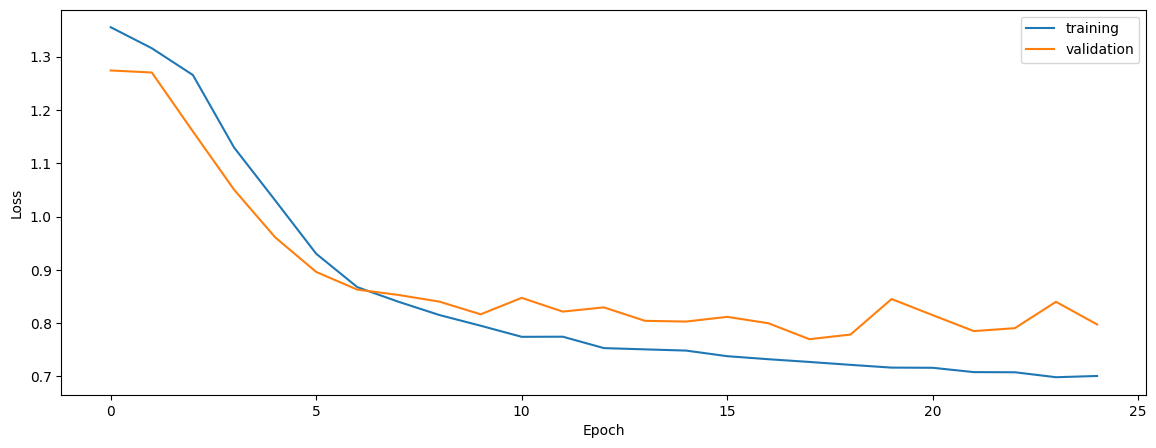

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


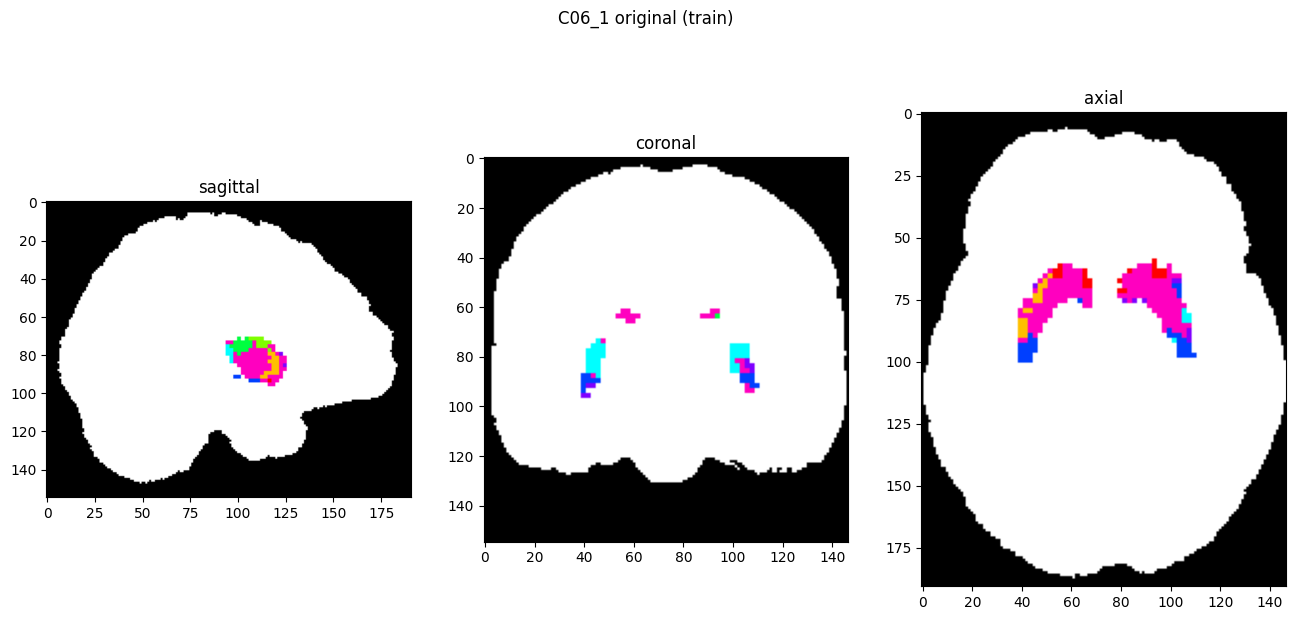

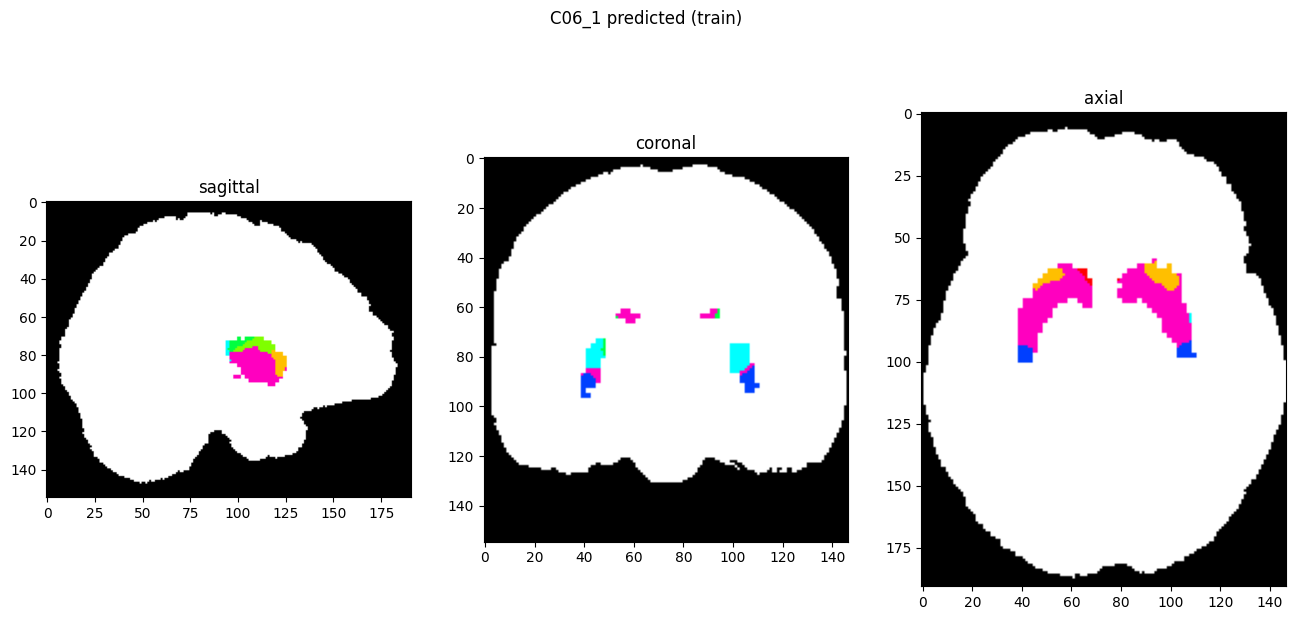

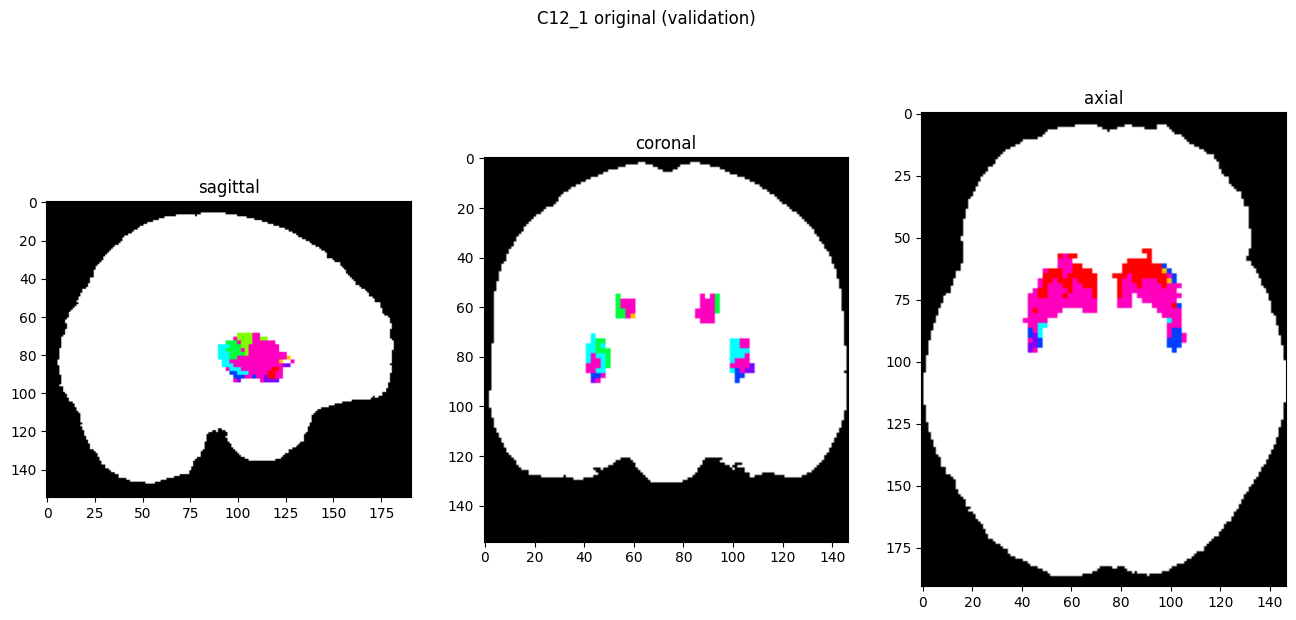

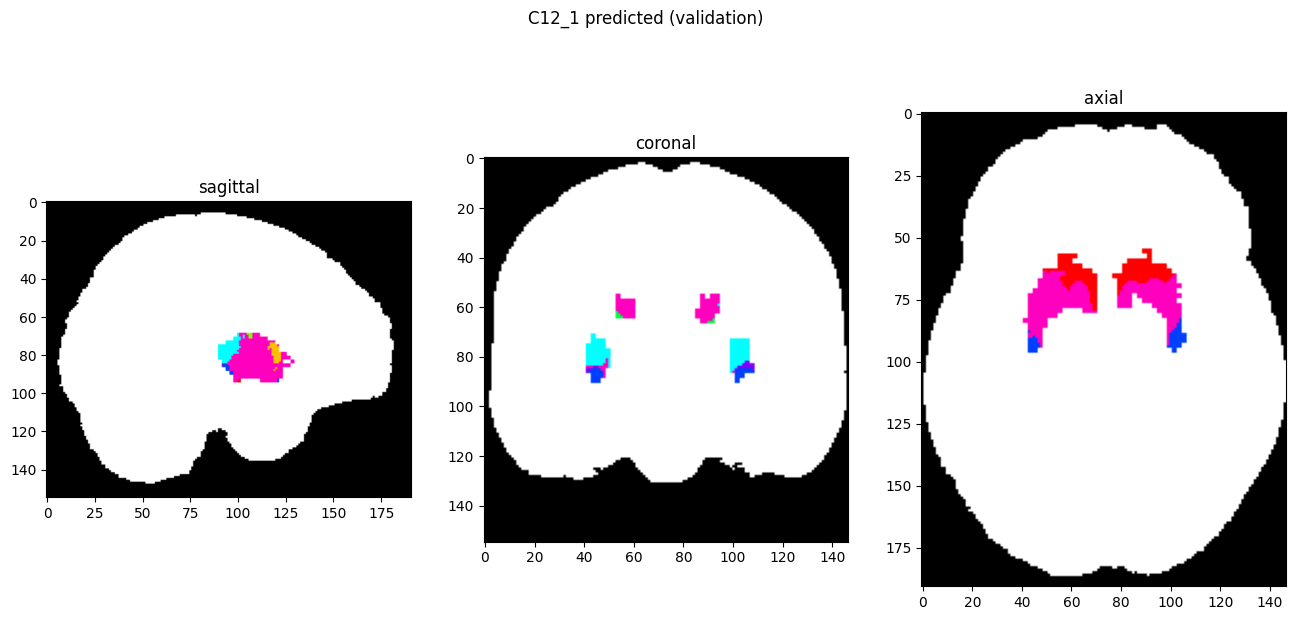

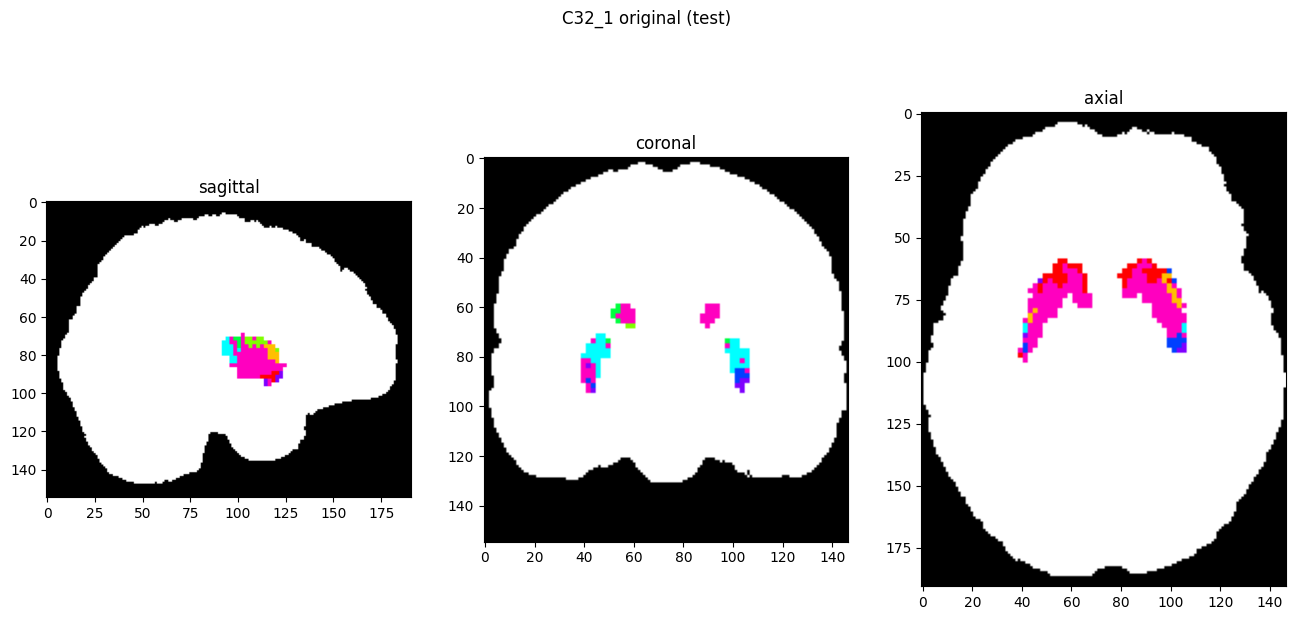

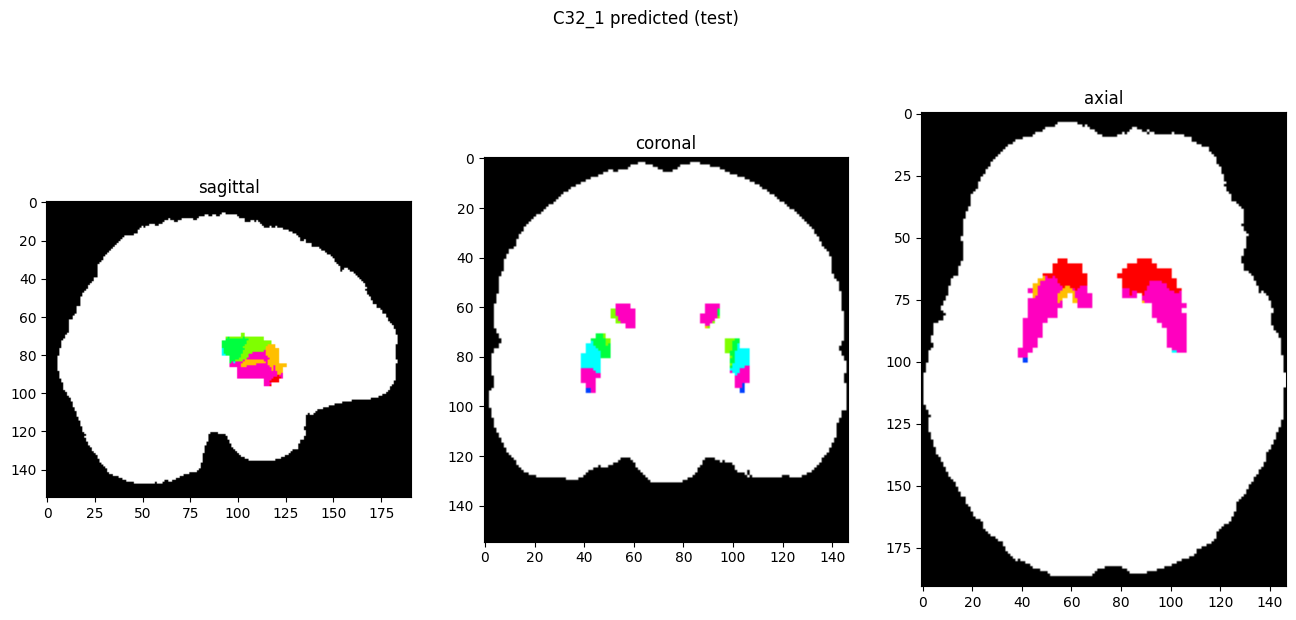

In [10]:
showResults(model, gen, threshold=0)